# Neural Based ISPs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.206862745098..1.1818627451].


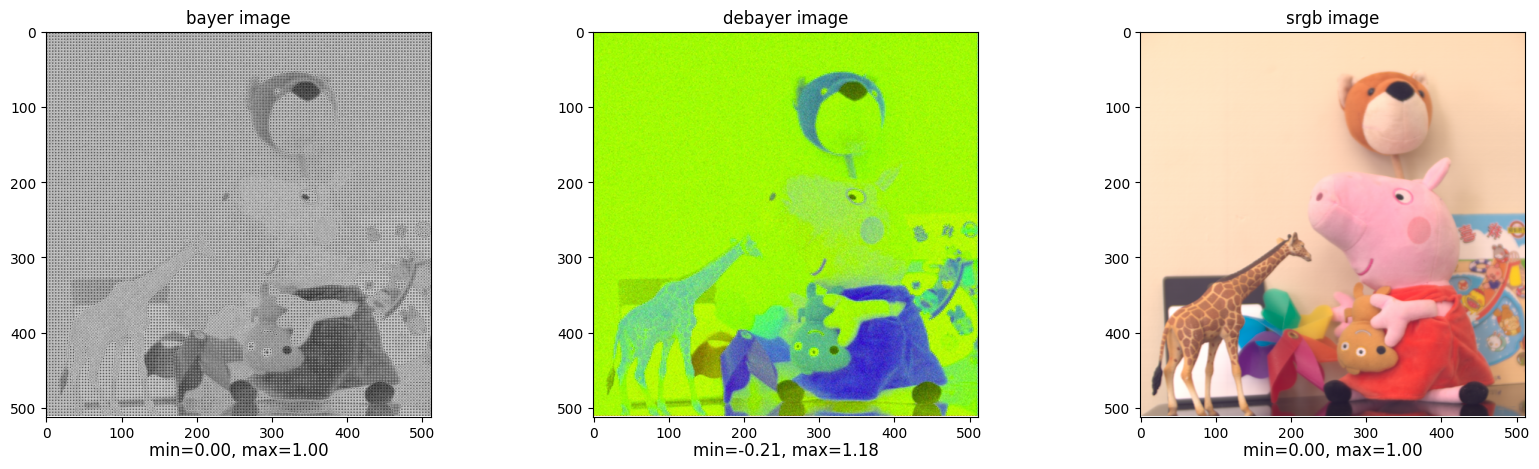

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from isp.utils.images import XYZ_TO_SRGB
from isp.utils.io import debayer_image
from isp.utils.io import bayer2rgb


def plot_images(images, titles):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))

    for i, (image, title) in enumerate(zip(images, titles)):
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(title)

        # Get minimum and maximum values of image
        image_min = np.min(image)
        image_max = np.max(image)

        # Add min and max values to plot
        text = f"min={image_min:.2f}, max={image_max:.2f}"
        axes[i].text(0.5, -0.1, text, transform=axes[i].transAxes,
                     fontsize=12, ha='center')

    plt.show()


gt = np.load("./data/raw2rgb/2019-08-25_006_gt.npy", allow_pickle=True)
sample = np.load("./data/raw2rgb/2019-08-25_006_sample.npy", allow_pickle=True)
input_img = sample.item().get('image') / 255
input_img_debayer = debayer_image(input_img)
input_rgb = bayer2rgb(input_img, "GRBG") 
gt_xyz  = gt.item().get('xyz')
xyz2srgb = XYZ_TO_SRGB()
gt_sRGB = xyz2srgb.XYZ_to_sRGB(gt_xyz)


plot_images([input_img, input_rgb, gt_sRGB], ['bayer image', 'debayer image', 'srgb image'])

## DH_ISP

![](figures/dh_isp.png)

In [4]:
from torch import nn
from isp.pipelines import DefaultPipeline
from isp.datasets import ImgDataModule
from isp.models import DhIspModel
import lightning as L

model = DhIspModel(
    in_dim=4,
    out_dim=3
)

pipeline = DefaultPipeline(
    model=model,
    img2feat=False,
    init=False,
)

dm = ImgDataModule(
    x_img=input_img_debayer,
    y_img=gt_sRGB,
)

trainer = L.Trainer(
    accelerator='gpu',
    max_epochs=5,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [5]:
trainer.fit(
    model=pipeline,
    datamodule=dm,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                             | Params | Mode 
-------------------------------------------------------------------------
0 | model       | DhIspModel                       | 4.7 K  | train
1 | mae_loss    | L1Loss                           | 0      | train
2 | de_metric   | DeltaE                           | 0      | train
3 | ssim_metric | StructuralSimilarityIndexMeasure | 0      | train
4 | psnr_metric | PeakSignalNoiseRatio             | 0      | train
-------------------------------------------------------------------------
4.7 K     Trainable params
0         Non-trainable params
4.7 K     Total params
0.019     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.19551].


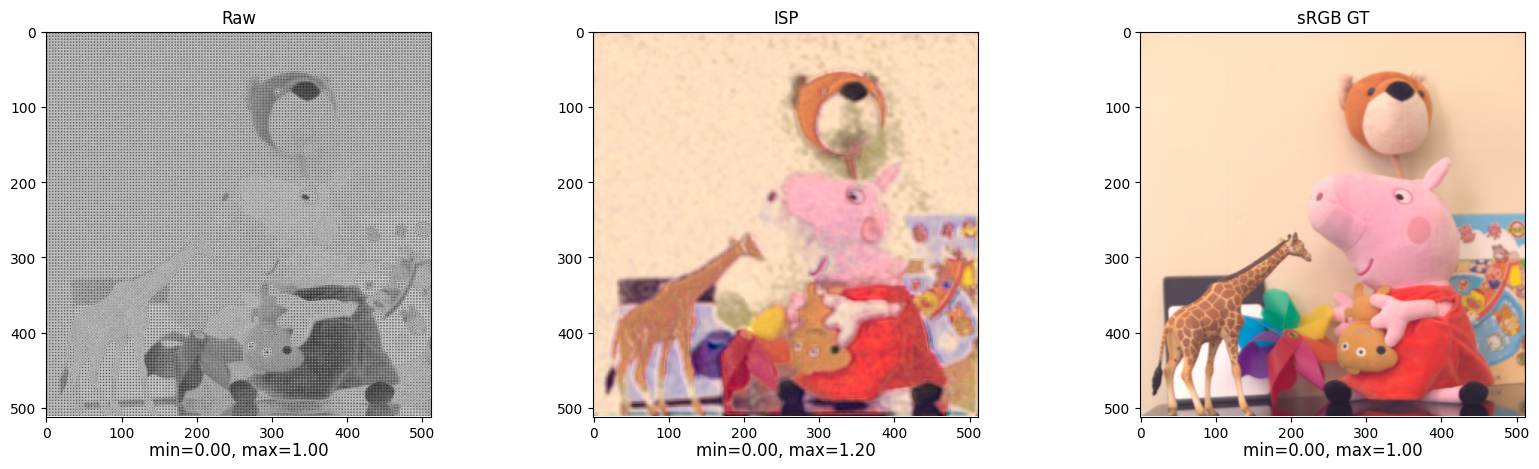

In [6]:
dm.setup('test')

pipeline = DefaultPipeline.load_from_checkpoint(
    'checkpoints/dh_isp.ckpt',
    model=model,
    img2feat=False,
).cpu()

x = dm.test_dataset.__getitem__(0)[0].unsqueeze(0)
dh_isp_img = pipeline.eval()(x).detach()

dh_isp_img = dh_isp_img.squeeze(0).permute(1, 2, 0).numpy()

plot_images([input_img, dh_isp_img, gt_sRGB],
            ['Raw','ISP', 'sRGB GT'])

In [7]:
from torch import nn
from isp.pipelines import DefaultPipeline
from isp.datasets import ImgDataModule
from isp.models import DhIspModel3ch
import lightning as L

model = DhIspModel3ch(
    in_dim=3,
    out_dim=3
)

pipeline = DefaultPipeline(
    model=model,
    img2feat=False,
    init=False,
)

dm = ImgDataModule(
    x_img=input_rgb,
    y_img=gt_sRGB,
)

trainer = L.Trainer(
    accelerator='gpu',
    max_epochs=5,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [8]:
trainer.fit(
    model=pipeline,
    datamodule=dm,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                             | Params | Mode 
-------------------------------------------------------------------------
0 | model       | DhIspModel3ch                    | 4.8 K  | train
1 | mae_loss    | L1Loss                           | 0      | train
2 | de_metric   | DeltaE                           | 0      | train
3 | ssim_metric | StructuralSimilarityIndexMeasure | 0      | train
4 | psnr_metric | PeakSignalNoiseRatio             | 0      | train
-------------------------------------------------------------------------
4.8 K     Trainable params
0         Non-trainable params
4.8 K     Total params
0.019     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0543278..1.24476].


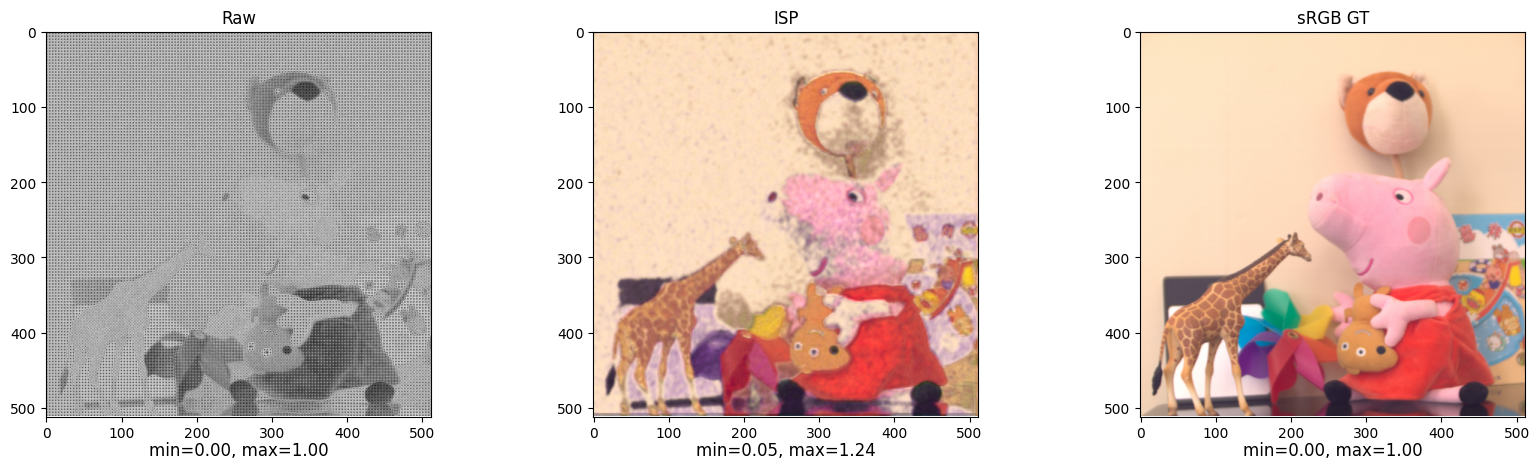

In [9]:
dm.setup('test')

pipeline = DefaultPipeline.load_from_checkpoint(
    'checkpoints/dh_isp3.ckpt',
    model=model,
    img2feat=False,
    init=False,
).cpu()

x = dm.test_dataset.__getitem__(0)[0].unsqueeze(0)
dh_isp_img = pipeline.eval()(x).detach()

dh_isp_img = dh_isp_img.squeeze(0).permute(1, 2, 0).numpy()

plot_images([input_img, dh_isp_img, gt_sRGB],
            ['Raw','ISP', 'sRGB GT'])

## MW_ISP

![](figures/mw_isp.png)

In [10]:
from torch import nn
from isp.pipelines import DefaultPipeline
from isp.datasets import ImgDataModule
from isp.models import MwIspModel
import lightning as L

model = MwIspModel()

pipeline = DefaultPipeline(
    model=model,
    img2feat=False,
    init=False
)

dm = ImgDataModule(
    x_img=input_rgb,
    y_img=gt_sRGB,
)

trainer = L.Trainer(
    accelerator='gpu',
    max_epochs=5,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [11]:
trainer.fit(
    model=pipeline,
    datamodule=dm,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                             | Params | Mode 
-------------------------------------------------------------------------
0 | model       | MwIspModel                       | 29.2 M | train
1 | mae_loss    | L1Loss                           | 0      | train
2 | de_metric   | DeltaE                           | 0      | train
3 | ssim_metric | StructuralSimilarityIndexMeasure | 0      | train
4 | psnr_metric | PeakSignalNoiseRatio             | 0      | train
-------------------------------------------------------------------------
29.2 M    Trainable params
96        Non-trainable params
29.2 M    Total params
116.858   Total estimated model params size (MB)
1491      Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.7084e+16..1.18914e+17].


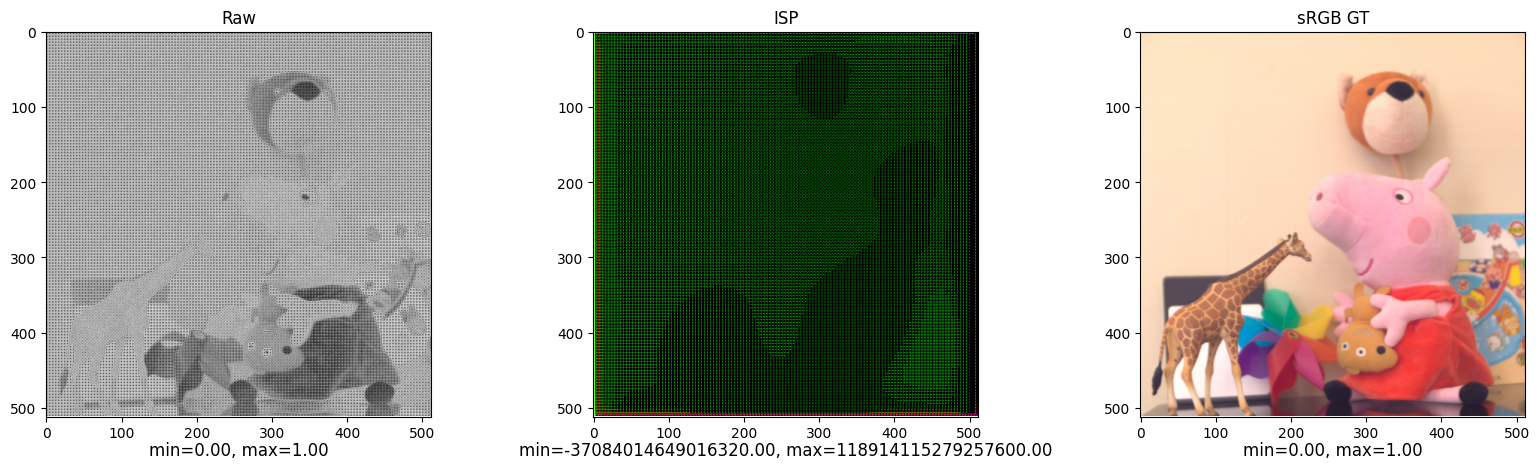

In [12]:
dm.setup('test')

x = dm.test_dataset.__getitem__(0)[0].unsqueeze(0)
dh_isp_img = pipeline.eval()(x).detach()

dh_isp_img = dh_isp_img.squeeze(0).permute(1, 2, 0).numpy()

plot_images([input_img, dh_isp_img, gt_sRGB],
            ['Raw','ISP', 'sRGB GT'])

## cmKAN

![](figures/cmKAN.png)
![](figures/cmKAN2.png)

In [13]:
from isp.models import CmKANModel
from isp.pipelines import DefaultPipeline
from isp.datasets import ImgDataModule
import lightning as L

model = CmKANModel(
    in_dims=[3],
    out_dims=[3],
    kernel_sizes=[3],
    grid_size=5,
    spline_order=3,
    residual_std=0.1,
    grid_range=[0.0, 1.0],
)

pipeline = DefaultPipeline(
    model=model,
    img2feat=False,
    init=True,
)

dm = ImgDataModule(
    x_img=input_rgb,
    y_img=gt_sRGB,
)

trainer = L.Trainer(
    accelerator='gpu',
    max_epochs=5,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [14]:
trainer.fit(
    model=pipeline,
    datamodule=dm,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                             | Params | Mode 
-------------------------------------------------------------------------
0 | model       | ConvSepKAN                       | 7.8 K  | train
1 | mae_loss    | L1Loss                           | 0      | train
2 | de_metric   | DeltaE                           | 0      | train
3 | ssim_metric | StructuralSimilarityIndexMeasure | 0      | train
4 | psnr_metric | PeakSignalNoiseRatio             | 0      | train
-------------------------------------------------------------------------
7.8 K     Trainable params
16        Non-trainable params
7.8 K     Total params
0.031     Total estimated model params size (MB)
56        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Exception ignored in: <function _releaseLock at 0x7fb287715a80>
Traceback (most recent call last):
  File "/home/gosha20777/miniconda3/envs/cst/lib/python3.12/logging/__init__.py", line 243, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.182144..1.10146].


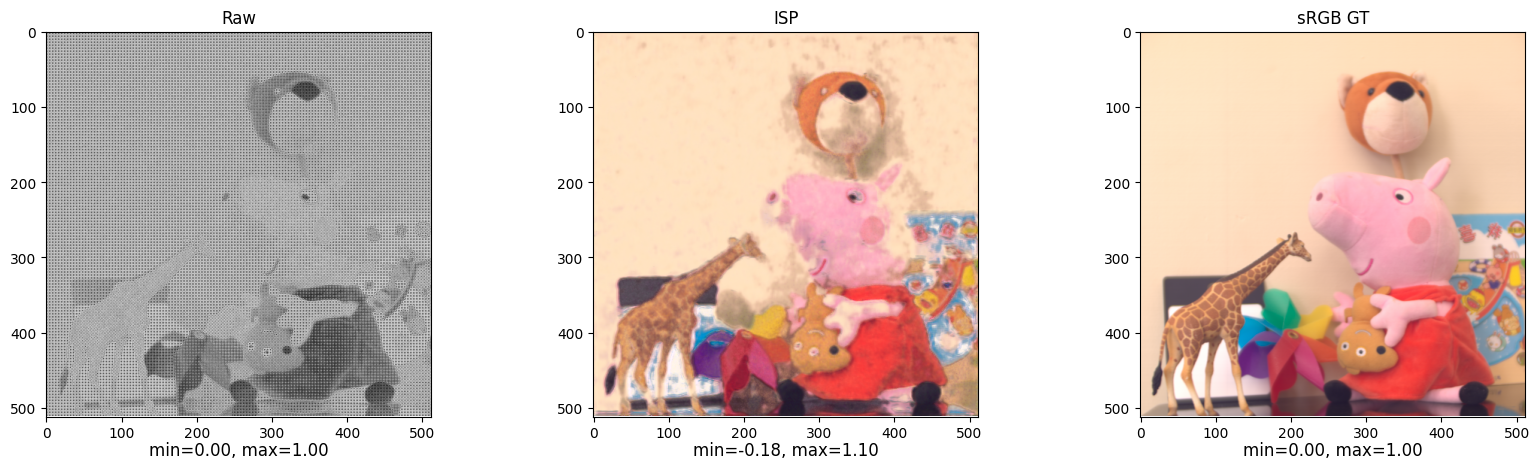

In [15]:
dm.setup('test')

pipeline = DefaultPipeline.load_from_checkpoint(
    'checkpoints/cmKAN.ckpt',
    model=model,
    img2feat=False,
    init=False,
).cpu()

x = dm.test_dataset.__getitem__(0)[0].unsqueeze(0)
dh_isp_img = pipeline.eval()(x).detach()

dh_isp_img = dh_isp_img.squeeze(0).permute(1, 2, 0).numpy()

plot_images([input_img, dh_isp_img, gt_sRGB],
            ['Raw','ISP', 'sRGB GT'])

- https://arxiv.org/pdf/2002.05509
- https://arxiv.org/pdf/2211.06770
- https://arxiv.org/pdf/2404.11569

# Unpaired ISPs

- https://colab.research.google.com/drive/1iijTTyjjQ-VErjkYMRW2NoxeLEj0p8Ft?usp=sharing